In [1]:
from mfglib.env import Environment
from mfglib.alg.utils import _ensure_free_tensor,tuple_prod
from mfglib.mean_field import mean_field
from typing import Literal, cast
import torch
from mfglib.alg.greedy_policy_given_mean_field import Greedy_Policy
import matplotlib.pyplot as plt
from mfglib.alg import MFOMO,PriorDescent, FictitiousPlay,OnlineMirrorDescent, TwoScaleLearning
from mfglib.metrics import exploitability_score
from mfglib.alg.q_fn import QFn
import scipy
import scienceplots
#plt.style.use(['science','no-latex'])
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from tqdm import tqdm

d:\Program Files\anaconda3\envs\mfg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
n=30
bar_loc=15
T=15
exp_name = 'beach'

import os
if not os.path.exists(f'results/{exp_name}'):
    os.makedirs(f'results/{exp_name}')

### Run two scale learning

In [5]:
env_instance = Environment.beach_bar(n=n, bar_loc=bar_loc, T=T)
solns, solns_mu, expls, diffs, runtimes = TwoScaleLearning(Q_speed = 0.55, mu_speed=1).solve(env_instance, max_iter=50000, verbose=True)
torch.save(solns, "results/beach/beach_pi_record.pt")
torch.save(solns_mu, "results/beach/beach_nu_record.pt")
torch.save(expls, "results/beach/beach_exp_record.pt")
torch.save(diffs, "results/beach/beach_diff_record.pt")
torch.save(runtimes, "results/beach/beach_time_record.pt")

torch.Size([30, 3])
            MFGLib v0.1.1 : A Library for Mean-Field Games             
                  (c) RADAR Research Lab, UC Berkeley                  

Environment summary:
	S=(30,)
	A(3,)
	T=15
	r_max=30

Algorithm summary:
	OnlineMirrorDescent(Q_speed=0.55, mu_speed=1)
	atol=0.001
	rtol=0.001
	max_iter=50000

-----------------------------------------------------------------------
| iter |  expl_n  | expl_n / expl_0 | argmin_{0..n} expl_i | time (s) |
-----------------------------------------------------------------------
|  0   | 11.68631 |     1.00000     |          0           |  0.000   |
|  1   | 3.80001  |     0.32517     |          1           |  0.008   |
|  2   | 4.87821  |     0.41743     |          1           |  0.016   |
|  3   | 4.37007  |     0.37395     |          1           |  0.023   |
|  4   | 3.67119  |     0.31414     |          4           |  0.030   |
|  5   | 2.52768  |     0.21629     |          5           |  0.036   |
|  6   | 1.80083  |     0.

### Run OMD

In [6]:
env_instance = Environment.beach_bar(n=n, bar_loc=bar_loc, T=T)
solns, expls, runtimes = OnlineMirrorDescent().solve(env_instance, max_iter=5000, verbose=True)
torch.save(solns, "results/beach/beach_MFE_pi_record.pt")
torch.save(expls, "results/beach/beach_MFE_exp_record.pt")
torch.save(runtimes, "results/beach/beach_MFE_time_record.pt")

torch.Size([30, 3])
            MFGLib v0.1.1 : A Library for Mean-Field Games             
                  (c) RADAR Research Lab, UC Berkeley                  

Environment summary:
	S=(30,)
	A(3,)
	T=15
	r_max=30

Algorithm summary:
	OnlineMirrorDescent(alpha=1.0)
	atol=0.001
	rtol=0.001
	max_iter=5000

-----------------------------------------------------------------------
| iter |  expl_n  | expl_n / expl_0 | argmin_{0..n} expl_i | time (s) |
-----------------------------------------------------------------------
|  0   | 11.68631 |     1.00000     |          0           |  0.000   |
|  1   | 7.74173  |     0.66246     |          1           |  0.008   |
|  2   | 3.52961  |     0.30203     |          2           |  0.016   |
|  3   | 13.19201 |     1.12884     |          2           |  0.022   |
|  4   | 11.99105 |     1.02608     |          2           |  0.027   |
|  5   | 16.75518 |     1.43374     |          2           |  0.032   |
|  6   | 21.96913 |     1.87990     |     

### Converngence

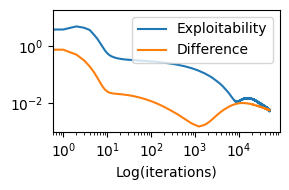

In [10]:
expls = torch.load("results/beach/beach_exp_record.pt")
diffs = torch.load("results/beach/beach_diff_record.pt")

plt.figure(figsize=(3, 2))
plt.plot(expls, label='Exploitability') 
plt.plot(diffs, label='Difference') 
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Log(iterations)')
plt.tight_layout()

plt.savefig('results/beach/beach_converge',dpi=300)

plt.show()

torch.Size([30, 3])


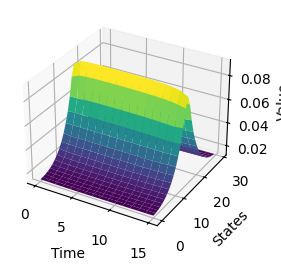

In [17]:
solns = torch.load("results/beach/beach_pi_record.pt")
solns_mu = torch.load("results/beach/beach_nu_record.pt")

pi = solns[-1]
nu = solns_mu[-1]

env_instance = Environment.beach_bar(n=n, bar_loc=bar_loc, T=T)

env_instance.update_initial_distribution(nu)
L = mean_field(env_instance, pi)
mu = torch.sum(L, axis=2)
mu_np = mu.numpy()

# Create meshgrid for X (days) and Y (states)
days = np.arange(mu.shape[0])  # [0, 1, 2]
states = np.arange(mu.shape[1])  # [0, 1, 2, 3]
X, Y = np.meshgrid(days, states, indexing='ij')  # Use 'ij' to align correctly

# Plotting
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Y, mu_np, cmap='viridis')

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("States")
ax.set_zlabel("Value")
fig.savefig(
    'results/beach/beach_CMFE.png',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1  # a small buffer around the edges
)
plt.show()


torch.Size([30, 3])


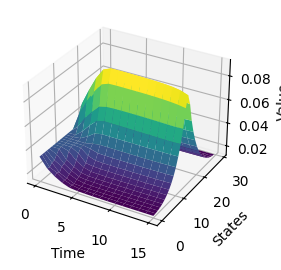

In [18]:
solns = torch.load("results/beach/beach_MFE_pi_record.pt")

pi = solns[-1]
env_instance = Environment.beach_bar(n=n, bar_loc=bar_loc, T=T)

L = mean_field(env_instance, pi)
mu = torch.sum(L, axis=2)
mu_MFE = mu.numpy()

# Create meshgrid for X (days) and Y (states)
days = np.arange(mu.shape[0])  # [0, 1, 2]
states = np.arange(mu.shape[1])  # [0, 1, 2, 3]
X, Y = np.meshgrid(days, states, indexing='ij')  # Use 'ij' to align correctly

# Plotting
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Y, mu_MFE, cmap='viridis')

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("States")
ax.set_zlabel("Value")

fig.savefig(
    'results/beach/beach_MFE.png',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1  # a small buffer around the edges
)
plt.show()

[0.0866118  0.09077422 0.09142584 0.09153704 0.09155422 0.09155492
 0.09152818 0.09148593 0.09139346 0.09128672 0.09111091 0.09086113
 0.09046263 0.08985054 0.08857922 0.08516506]
[0.0866118  0.09077422 0.09142584 0.09153704 0.09155422 0.09155492
 0.09152818 0.09148593 0.09139346 0.09128672 0.09111091 0.09086113
 0.09046263 0.08985054 0.08857922 0.0866118  0.09077422 0.09142584
 0.09153704 0.09155422 0.09155492 0.09152818 0.09148593 0.09139346
 0.09128672 0.09111091 0.09086113 0.09046263 0.08985054 0.08857922
 0.0866118  0.09077422 0.09142584 0.09153704 0.09155422 0.09155492
 0.09152818 0.09148593 0.09139346 0.09128672 0.09111091 0.09086113
 0.09046263 0.08985054 0.08857922 0.0866118  0.09077422 0.09142584
 0.09153704 0.09155422 0.09155492 0.09152818 0.09148593 0.09139346
 0.09128672 0.09111091 0.09086113 0.09046263 0.08985054 0.08857922]


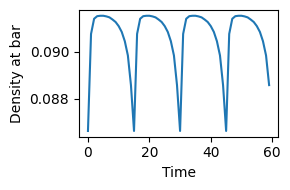

In [48]:
num_cycle = 3
print(mu_np[:,bar_loc])
mu_agg = np.hstack((mu_np[:T, bar_loc], mu_np[:T, bar_loc], mu_np[:T, bar_loc], mu_np[:T, bar_loc]))
print(mu_agg)
plt.figure(figsize=(3, 2))
plt.plot(mu_agg, label='CMFE')
plt.ylabel('Density at bar')
plt.xlabel('Time')
plt.tight_layout()

plt.savefig('results/beach/beach_cycle',dpi=300)
plt.show()

Text(0.5, 0, 'Time')

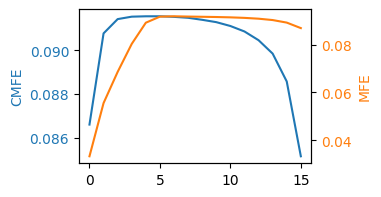

In [29]:
fig, ax1 = plt.subplots(figsize=(3,2))
ax1.plot(mu_np[:, bar_loc], color='tab:blue', label='CMFE')
ax1.set_ylabel('CMFE', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(mu_MFE[:, bar_loc], color='tab:orange', label='MFE')
ax2.set_ylabel('MFE', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.xlabel('Time')


### Contraction test

In [36]:
def TV(nu, mu):
    """
    Compute the Total Variation distance between two distributions.
    """
    return torch.sum(torch.abs(nu - mu)) / 2.0

def TV_np(nu, mu):
    return np.sum(np.abs(nu - mu)) / 2.0

In [15]:
n=100
bar_loc=round(n/2)
T=5

In [16]:
torch.manual_seed(0)
max_iter = 200
ratio_record = []

for i in tqdm(range(max_iter)):
    nu1 = torch.rand(n)
    nu1 = nu1 / nu1.sum()
    env_instance = Environment.beach_bar(n=n, bar_loc=bar_loc, T=T)
    env_instance.update_initial_distribution(nu1)
    solns, expls, runtimes = OnlineMirrorDescent().solve(env_instance, max_iter=5000, verbose=False)
    pi = solns[-1]
    L = mean_field(env_instance, pi)
    mu = L.sum(dim=tuple(range(2, L.ndim)))
    mu_T1 = mu[-1]

    nu2 = torch.rand(n)
    nu2 = nu2 / nu2.sum()
    env_instance = Environment.beach_bar(n=n, bar_loc=bar_loc, T=T)
    env_instance.update_initial_distribution(nu2)
    solns, expls, runtimes = OnlineMirrorDescent().solve(env_instance, max_iter=5000, verbose=False)
    pi = solns[-1]
    L = mean_field(env_instance, pi)
    mu = L.sum(dim=tuple(range(2, L.ndim)))
    mu_T2 = mu[-1]

    ratio = TV(mu_T1, mu_T2) / TV(nu1, nu2)
    ratio_record.append(ratio.item())


100%|██████████| 200/200 [05:19<00:00,  1.60s/it]


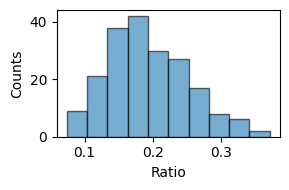

In [17]:
plt.figure(figsize=(3, 2))
plt.hist(ratio_record, bins=10, density=False, alpha=0.6, edgecolor='black')
plt.xlabel('Ratio')
plt.ylabel('Counts')
plt.tight_layout()
plt.savefig(f'results/{exp_name}/contraction_T{T}_n{n}.png',dpi=300)


### Cyclic pattern

In [42]:
n=30
bar_loc=round(n/2)
T=15
print(exp_name)

beach


In [44]:
torch.manual_seed(0)
population_size = 10

solns = torch.load(f"results/{exp_name}/pi_record.pt")
IC = torch.load(f"results/{exp_name}/nu_record.pt")
pi = solns[-1]
nu = IC[-1]
print(nu)

s_t = torch.multinomial(nu, num_samples=1, replacement=True)
print(s_t)
pi_t = pi[0, s_t].ravel()
a_t = torch.multinomial(pi_t, num_samples=1, replacement=True)
print(pi_t)
print(a_t)

tensor([0.0137, 0.0139, 0.0143, 0.0151, 0.0163, 0.0179, 0.0200, 0.0227, 0.0262,
        0.0307, 0.0363, 0.0434, 0.0520, 0.0631, 0.0781, 0.0866, 0.0781, 0.0631,
        0.0520, 0.0434, 0.0363, 0.0307, 0.0262, 0.0227, 0.0200, 0.0179, 0.0163,
        0.0151, 0.0144, 0.0140])
tensor([2])
tensor([1.5973e-07, 9.3451e-01, 6.5485e-02])
tensor([1])


In [45]:
p = torch.zeros(n)
p_still = 0.5

prs = [(1 - p_still) / 2, p_still, (1 - p_still) / 2]
for epsilon, pr in zip([-1, 0, 1], prs):
    s_next = min(max(s_t + a_t - 1 + epsilon, 0), n - 1)
    p[s_next] += pr
print(p)

tensor([0.0000, 0.2500, 0.5000, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])


In [46]:
torch.manual_seed(0)

solns = torch.load(f"results/{exp_name}/pi_record.pt")
IC = torch.load(f"results/{exp_name}/nu_record.pt")
pi = solns[-1]
nu = IC[-1]

p_still = 0.5
prs = [(1 - p_still) / 2, p_still, (1 - p_still) / 2]

env_instance = Environment.beach_bar(n=n, bar_loc=bar_loc, T=T)
env_instance.update_initial_distribution(nu)
L = mean_field(env_instance, pi)
mu = L.sum(dim=tuple(range(2, L.ndim)))
mu_T = mu[-1].numpy()

final_diff_record = []

population_size_trail = np.arange(2,510, 10)
for population_size in tqdm(population_size_trail):
    final_state_record = []

    for agent in range(population_size):
        s_t = torch.multinomial(nu, num_samples=1, replacement=True)
        for t in range(0, T):
            pi_t = pi[t, s_t]
            pi_t = pi[0, s_t].ravel()
            a_t = torch.multinomial(pi_t, num_samples=1, replacement=True)

            p = torch.zeros(n)
            for epsilon, pr in zip([-1, 0, 1], prs):
                s_next = min(max(s_t + a_t - 1 + epsilon, 0), n - 1)
                p[s_next] += pr

            s_t = torch.multinomial(p, num_samples=1, replacement=True)
            
        final_state_record.append(s_t.item())

    counts = np.bincount(final_state_record, minlength=n)  
    emp_dist = counts/ counts.sum()
    final_diff_record.append(TV_np(emp_dist, nu.numpy()))

100%|██████████| 51/51 [00:44<00:00,  1.14it/s]


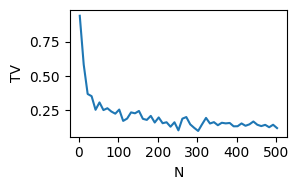

In [47]:
plt.figure(figsize=(3, 2))
plt.plot(population_size_trail,final_diff_record)
plt.xticks([0,100, 200, 300,400,500])
plt.xlabel('N')
plt.ylabel('TV')
plt.tight_layout()
plt.savefig(f'results/{exp_name}/approximate.png',dpi=300)
plt.show()

### No action cost env

In [2]:
n=30
bar_loc=15
T=15
exp_name = 'beach_state'

import os
if not os.path.exists(f'results/{exp_name}'):
    os.makedirs(f'results/{exp_name}')

In [3]:
env_instance = Environment.beach_bar_state(n=n, bar_loc=bar_loc, T=T)
solns, solns_mu, expls, diffs, runtimes = TwoScaleLearning(Q_speed = 0.55, mu_speed=1).solve(env_instance, max_iter=50000, verbose=True)
torch.save(solns, f"results/{exp_name}/pi_record.pt")
torch.save(solns_mu, f"results/{exp_name}/nu_record.pt")
torch.save(expls, f"results/{exp_name}/exp_record.pt")
torch.save(diffs, f"results/{exp_name}/diff_record.pt")

            MFGLib v0.1.1 : A Library for Mean-Field Games             
                  (c) RADAR Research Lab, UC Berkeley                  

Environment summary:
	S=(30,)
	A(3,)
	T=15
	r_max=30

Algorithm summary:
	OnlineMirrorDescent(Q_speed=0.55, mu_speed=1)
	atol=0.001
	rtol=0.001
	max_iter=50000

-----------------------------------------------------------------------
| iter |  expl_n  | expl_n / expl_0 | argmin_{0..n} expl_i | time (s) |
-----------------------------------------------------------------------
|  0   | 11.69971 |     1.00000     |          0           |  0.000   |
|  1   | 3.78078  |     0.32315     |          1           |  0.007   |
|  2   | 4.97226  |     0.42499     |          1           |  0.015   |
|  3   | 4.40481  |     0.37649     |          1           |  0.024   |
|  4   | 3.70938  |     0.31705     |          4           |  0.031   |
|  5   | 2.52314  |     0.21566     |          5           |  0.040   |
|  6   | 1.77742  |     0.15192     |         

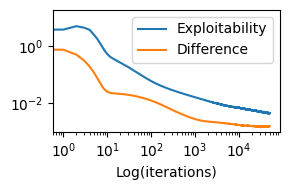

In [4]:
expls = torch.load(f"results/{exp_name}/exp_record.pt")
diffs = torch.load(f"results/{exp_name}/diff_record.pt")

plt.figure(figsize=(3, 2))
plt.plot(expls, label='Exploitability') 
plt.plot(diffs, label='Difference') 
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Log(iterations)')
plt.tight_layout()

plt.savefig(f'results/{exp_name}/converge',dpi=300)

plt.show()

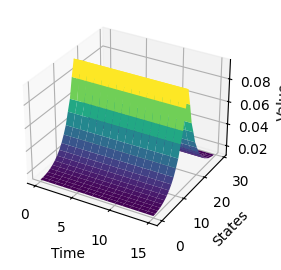

In [7]:
solns = torch.load(f"results/{exp_name}/pi_record.pt")
solns_mu = torch.load(f"results/{exp_name}/nu_record.pt")

pi = solns[-1]
nu = solns_mu[-1]

env_instance = Environment.beach_bar(n=n, bar_loc=bar_loc, T=T)

env_instance.update_initial_distribution(nu)
L = mean_field(env_instance, pi)
mu = torch.sum(L, axis=2)
mu_np_state = mu.numpy()

# Create meshgrid for X (days) and Y (states)
days = np.arange(mu.shape[0])  # [0, 1, 2]
states = np.arange(mu.shape[1])  # [0, 1, 2, 3]
X, Y = np.meshgrid(days, states, indexing='ij')  # Use 'ij' to align correctly

# Plotting
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Y, mu_np_state, cmap='viridis')

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("States")
ax.set_zlabel("Value")
fig.savefig(
    f'results/{exp_name}/CMFE.png',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1  # a small buffer around the edges
)
plt.show()


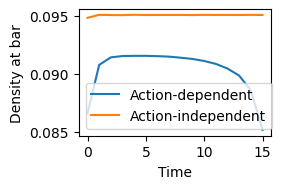

In [ ]:
solns = torch.load("results/beach/beach_pi_record.pt")
solns_mu = torch.load("results/beach/beach_nu_record.pt")

pi = solns[-1]
nu = solns_mu[-1]

env_instance = Environment.beach_bar(n=n, bar_loc=bar_loc, T=T)

env_instance.update_initial_distribution(nu)
L = mean_field(env_instance, pi)
mu = torch.sum(L, axis=2)
mu_np = mu.numpy()

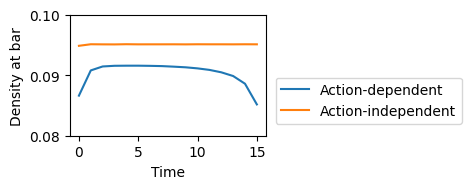

In [28]:
plt.figure(figsize=(5, 2))
plt.plot(mu_np[:, bar_loc], color='tab:blue', label='Action-dependent')
plt.plot(mu_np_state[:, bar_loc], color='tab:orange', label='Action-independent')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Density at bar')
plt.ylim(0.08, 0.1)
plt.legend(loc=(1.05, 0.1))
plt.tight_layout()
plt.savefig(f'results/{exp_name}/density_bar',dpi=300)